In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=172af214-41ff-426d-8960-b27a619e8ff2
To: /home/jupyter/IT_data.h5
100%|██████████| 384M/384M [00:03<00:00, 99.6MB/s] 


'IT_data.h5'

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [14]:
from utils import load_it_data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import torch
from torchvision.models import ResNet, resnet50, ResNet50_Weights
import pickle
from tqdm import tqdm

In [8]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)
layers = ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]

In [5]:
def extract_activations(self, stimuli, layer) :
    """extract the activations of the model for the given stimuli and layer

    Args:
        model (model): model we want to extract the activations from
        stimuli (ndarray): input data of the processed image's pixels

    Returns:
        dict: dictionary containing the activations for each layer of the model
    """    
    stimuli = torch.tensor(stimuli)
    activations = []
    for x in stimuli : 
        x = self.conv1(x.unsqueeze(0))
        if layer == 'conv1' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().numpy())
            continue
        
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        if layer == 'layer1' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().numpy())
            continue
    
        x = self.layer2(x)
        if layer == 'layer2' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().numpy())
            continue
        
        x = self.layer3(x)
        if layer == 'layer3' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().numpy())
            continue
    
        x = self.layer4(x)
        if layer == 'layer4' :       
            activations.append(torch.flatten(x.squeeze(0)).detach().numpy())
            continue
        
        x = self.avgpool(x)
        if layer == 'avgpool' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().numpy())
            continue
    return activations

ResNet.extract_activations = extract_activations

In [6]:
# load the pre-trained ResNet50 model
model = resnet50(weights=ResNet50_Weights.DEFAULT) # include_top = False?
model.eval()
print()

In [7]:
#Preprocess the stimuli (already done)
"""preprocess = weights.transforms()
img_transformed = preprocess(stimuli)
"""

'preprocess = weights.transforms()\nimg_transformed = preprocess(stimuli)\n'

In [ ]:
# extract the activations of the layers and apply PCA on each layer to store the first 1000PCs
for layer in tqdm(layers) : 
    activations_train = model.extract_activations(stimulus_train, layer)
    pca = PCA(n_components=1000)
    pca.fit(activations_train)    
    with open(layer+'_train.pkl','wb') as f:
        pickle.dump(pca.transform(activations_train), f)
    with open(layer+'_val.pkl','wb') as f:
        pickle.dump(pca.transform(model.extract_activations(stimulus_val, layer)), f)
    with open(layer+'_test.pkl','wb') as f:
        pickle.dump(pca.transform(model.extract_activations(stimulus_test, layer)), f)

 17%|█▋        | 1/6 [06:02<30:11, 362.33s/it]

In [23]:
def best_alpha_Ridge(X, y, alphas):
    """implement cross validation to find the best alpha for Ridge regression

    Args:
        X (ndarray): input data
        y (ndarray): output data, neuronal activity
        alphas (list of double): list of alpha to test

    Returns:
        tuple (double, ndarray): best alpha and all the scores for each alpha
    """
    scores = []
    for alpha in alphas:
        model = Ridge(alpha=alpha)
        cv_scores = cross_val_score(model, X, y, cv=5)
        scores.append(np.mean(cv_scores))
    return alphas[np.argmax(scores)], scores

def plot_RidgeCV(alphas, scores):
    """plot the scores for each alpha

    Args:
        alphas (list of double): list of alpha that were tested
        scores (list of double): list of scores for each alpha
    """
    plt.figure(figsize=(3,2))
    plt.plot(alphas, scores)
    plt.xlabel('alpha')
    plt.ylabel('r2 score')
    plt.show()
    
def RidgeCV(X, y, alphas):
    """find the best alpha for Ridge regression and plot the scores for each alpha, then fit the model with the best alpha

    Args:
        X (ndarray): input data
        y (ndarray): output data, neuronal activity
        alphas (list of double): list of alpha to test

    Returns:
        tuple (model, double): the ridge model fitted with the best alpha and the corresponding alpha
    """
    best_alpha, scores = best_alpha_Ridge(X, y, alphas)
    plot_RidgeCV(alphas, scores)
    print('The best alpha is', best_alpha)
    model = Ridge(alpha=best_alpha)
    model.fit(X, y)
    return model, best_alpha



R2 score for conv1 in function of the parameter alpha : 


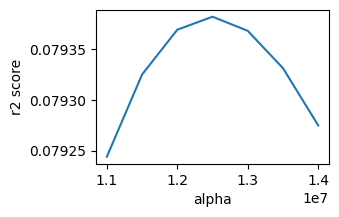

The best alpha is 12500000


R2 score for layer1 in function of the parameter alpha : 


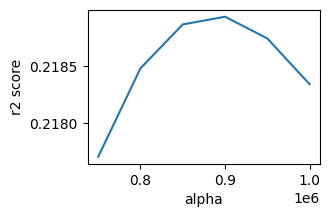

The best alpha is 900000


R2 score for layer2 in function of the parameter alpha : 


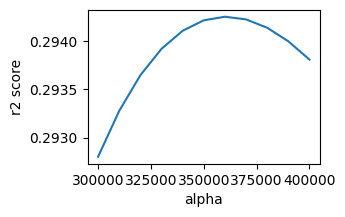

The best alpha is 360000


R2 score for layer3 in function of the parameter alpha : 


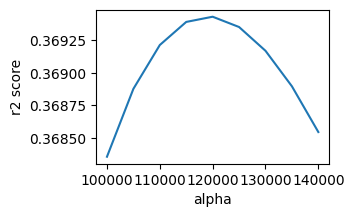

The best alpha is 120000


R2 score for layer4 in function of the parameter alpha : 


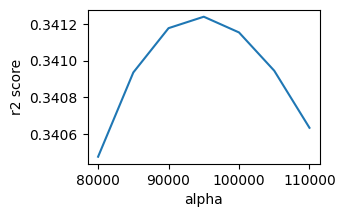

The best alpha is 95000


R2 score for avgpool in function of the parameter alpha : 


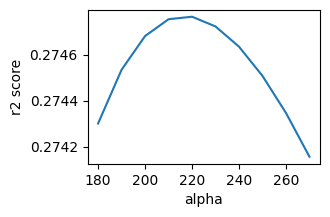

The best alpha is 220


In [43]:
# Use the PCs of each layer to predict the neural activity using linear regression models
models = {}
best_alphas = {}
alphas = {'conv1' : [11000000, 11500000, 12000000, 12500000, 13000000, 13500000, 14000000], 
          'layer1' : [750000, 800000, 850000, 900000, 950000, 1000000], 
          'layer2' : [300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000], 
          'layer3' : [100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000], 
          'layer4' : [80000, 85000, 90000, 95000, 100000, 105000, 110000], 
          'avgpool' : [180, 190, 200, 210, 220, 230, 240, 250, 260, 270]}

for layer in layers : 
    with open(layer+'_train.pkl', 'rb') as f:
        activations_train = pickle.load(f)  
    print('\n\nR2 score for', layer, 'in function of the parameter alpha : ')
    models[layer], best_alphas[layer] = RidgeCV(activations_train, spikes_train, alphas[layer])

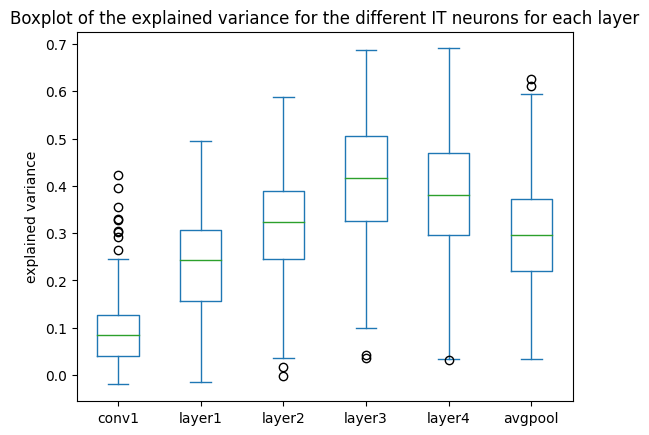

In [63]:
# Evaluate the models on the validation set
import pandas as pd
var = pd.DataFrame()
for layer in layers : 
    with open(layer+'_val.pkl', 'rb') as f:
        activations_val = pickle.load(f)  
    var[layer] = explained_variance_score(spikes_val, models[layer].predict(activations_val), multioutput = 'raw_values')

var.plot(kind='box', title='Boxplot of the explained variance for the different IT neurons for each layer', ylabel='explained variance')
plt.show()